In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore") 


import plotly.graph_objects as go

import xgboost as xgb

In [2]:
print('xgboost version: ', xgb.__version__)

xgboost version:  1.7.6


In [3]:
tsla_df = pd.read_csv('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/tsla.us.txt')
tsla_df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0


In [4]:
tsla_df.isnull().sum(axis = 0)

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

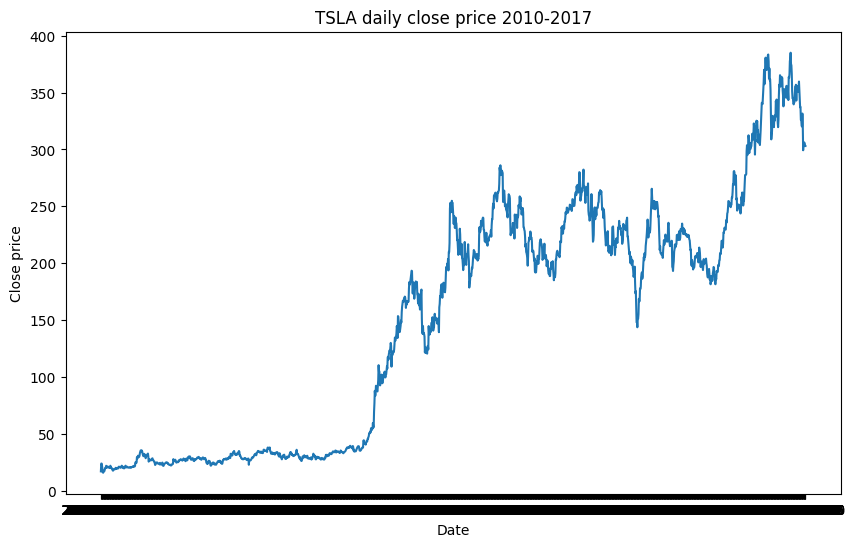

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=tsla_df)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.title('TSLA daily close price 2010-2017')
plt.show()

In [6]:
# Train data = 80% of the whole data set, test 10%, val 10%
train_size = 0.8
test_size = 0.1
validation_size = 0.1

train_end = int(len(tsla_df) * train_size)
test_end = train_end + int(len(tsla_df) * test_size)

train_data = tsla_df.iloc[:train_end]
test_data = tsla_df.iloc[train_end:test_end]
validation_data = tsla_df.iloc[test_end:]

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_data['Date'], y=train_data['Close'], mode='lines', name='Train data'))
fig.add_trace(go.Scatter(x=test_data['Date'], y=test_data['Close'], mode='lines', name='Test data'))
fig.add_trace(go.Scatter(x=validation_data['Date'], y=validation_data['Close'], mode='lines', name='Validation data'))


fig.update_layout(
    title='TSLA daily close price 2010-2017',
    xaxis_title='Date',
    yaxis_title='Close price',
)

fig.show()

In [8]:
X_train = train_data.drop(columns=['Close', 'Date'])
y_train = train_data['Close']
X_validation = validation_data.drop(columns=['Close', 'Date'])
y_validation = validation_data['Close'] 
X_test = test_data.drop(columns=['Close', 'Date'])

In [9]:
# small parameter testing
estimator_values = [50, 100, 150]
max_depth_values = [3, 4, 5]
learning_rate_values = [0.01, 0.1, 0.2]

best_params = {'n_estimators': None, 'max_depth': None, 'learning_rate': None}
best_mse = float('inf')

for n_estimators in estimator_values:
    for max_depth in max_depth_values:
        for learning_rate in learning_rate_values:
            bst = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
            
            bst.fit(X_train, y_train)

            test_preds = bst.predict(X_test)

            test_mse = mean_squared_error(test_data['Close'], test_preds)
            
            if test_mse < best_mse:
                best_mse = test_mse
                best_params['n_estimators'] = n_estimators
                best_params['max_depth'] = max_depth
                best_params['learning_rate'] = learning_rate

print("Best parameters:")
print(best_params)
print(f'Best Test Mean Squared Error: {best_mse:.2f}')

Best parameters:
{'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}
Best Test Mean Squared Error: 4.04


In [10]:
xgb_model = xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate']
)
xgb_model.fit(X_train, y_train)

validation_preds = xgb_model.predict(X_validation)

validation_mse = mean_squared_error(y_validation, validation_preds)
print(f'Mean Squared Error on the validation set: {validation_mse:.2f}')

Mean Squared Error on the validation set: 2912.53


In [11]:
test_preds = xgb_model.predict(X_test)

test_mse = mean_squared_error(test_data['Close'], test_preds)
print(f'Mean Squared Error on the test set: {test_mse:.2f}')

Mean Squared Error on the test set: 4.04


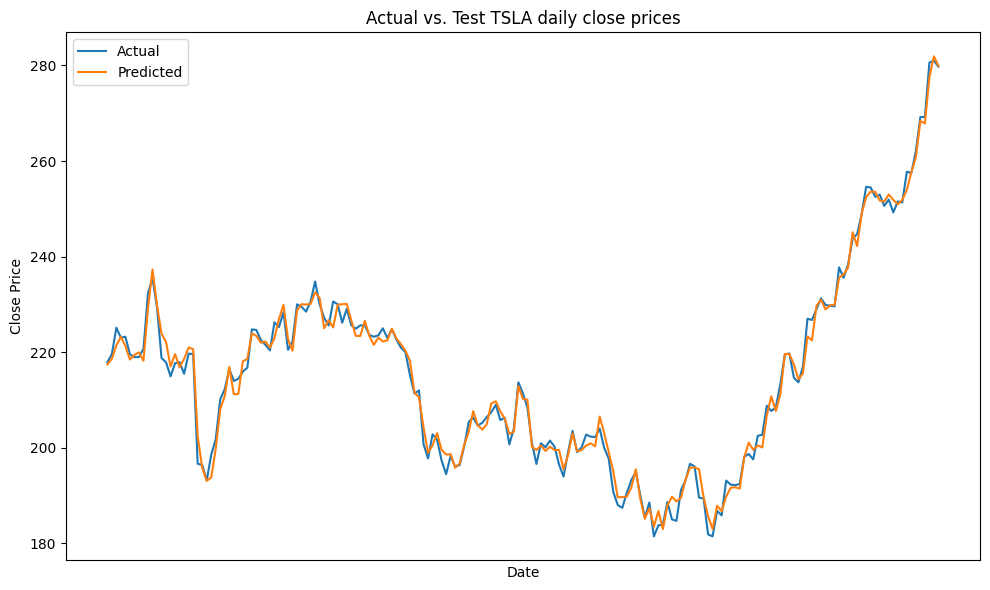

In [12]:
# Actual vs test
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], test_data['Close'], label='Actual')
plt.plot(test_data['Date'], test_preds, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Test TSLA daily close prices')
plt.legend()
plt.xticks([])
plt.tight_layout()
plt.show()

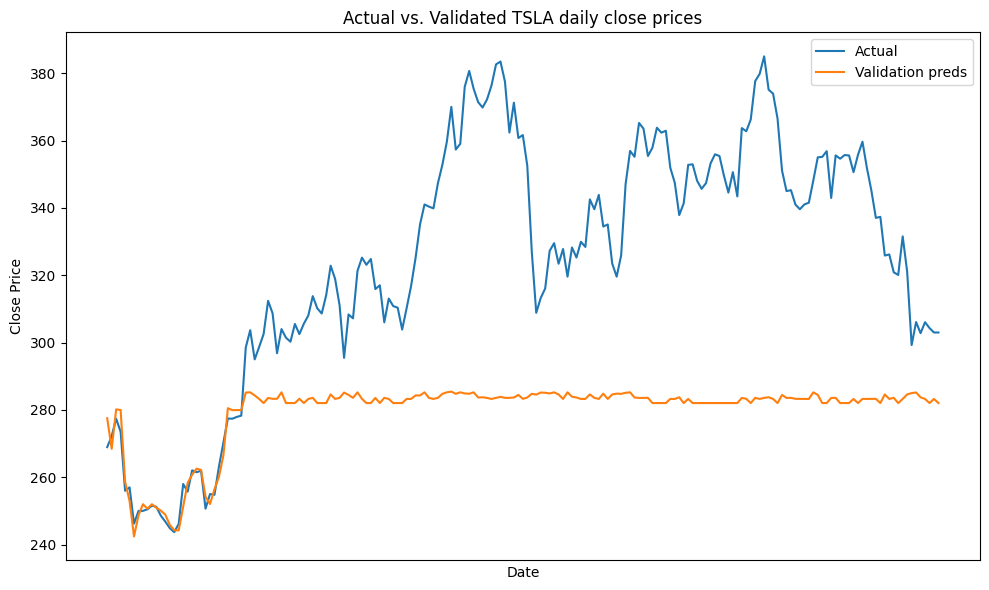

In [13]:
# Actual vs validation
plt.figure(figsize=(10, 6))
plt.plot(validation_data['Date'], validation_data['Close'], label='Actual')
plt.plot(validation_data['Date'], validation_preds, label='Validation preds')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Validated TSLA daily close prices')
plt.legend()
plt.xticks([])
plt.tight_layout()
plt.show()